In [1]:
import sdeint
import numpy as np
import random as rand
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from abc_env_stoch import ABCflow
from naive_agents import DoNothing, FixedPhi
from scipy.stats import norm

In [2]:
def abc_flow(y, t, *args):
    """
    abc flow with added control velocity
    
    args:
    y (np.array): np.array of length 3 specifying a particles current location
    t (list): list of floats with the time steps to solve for
    a,b,c (float): coeffcients or the abc flows
    control (array): float array of length 3 with the velocity components of the control term
    
    """
    control=args[0]
    a=args[1]
    b=args[2]
    c=args[3]
    
    X, Y, Z = y
    dydt = np.array([a*np.sin(Z)+c*np.cos(Y)+control[0], b*np.sin(X)+a*np.cos(Z)+control[1], c*np.sin(Y)+b*np.cos(X)+control[2]])
    return dydt



def brownian(x, t, *args):
    var = args[0]
    arr = np.eye(3) * var
    return arr

def closure(func, *args):
    def newfunc(x, t):
        return func(x, t, *args)
    return newfunc

In [3]:
def plotLambda(t_end, sep_dist=0.2*np.pi, a=1., b=0.7,c=0.43, kappa=0.001,seperate=False, deltaT=0.01):
    type_plot = "together"
    if seperate:
        type_plot = "seperate"
    
    t=np.arange(0,t_end,deltaT)
    num_episodes=1000
    lam=[]
    for i in range(num_episodes):
        s1=np.random.rand(3)*2*np.pi
        direction=np.random.rand(3)-0.5
        seperation=(direction/np.sqrt(direction@direction))*sep_dist
        s2=s1+seperation
        
        
        
        traj1 = sdeint.itoint(closure(abc_flow,np.zeros(3),a,b,c),
                                     closure(brownian, kappa*deltaT),
                                     s1,
                                     t)
        
        traj2 = sdeint.itoint(closure(abc_flow,np.zeros(3),a,b,c),
                                     closure(brownian, kappa*deltaT),
                                     s2,
                                     t)
        
        
        dist=np.sqrt(np.sum((traj1-traj2)*(traj1-traj2), axis=1))
        start_d=dist[0]
        end_d=dist[-1]
        lam.append((np.log(end_d/start_d))/t_end)
    mu, sigma = norm.fit(lam)
    print(f"t={t_end} lyapunov_mu: {mu}, lyapunov_sigma: {sigma}")
    plt.hist(lam,bins=75,density=True)
    plt.title(f"Histogram with observation time={t_end} sample_size={num_episodes}")
    plt.xlabel("lambda")
    plt.ylabel("prob density")
    plt.savefig(f'lyapunov_dists/{t_end}LambdaDensity_{type_plot}.png')
    if seperate:
        plt.clf()

In [36]:
def expected_prop(r,scaling,phi,lyapunov,r_d,kramer_d2):
    return scaling*(1/r)*np.power((r_d/r),(2*(phi-lyapunov)*kramer_d2))


def expo(x,a,b):
    return a*np.exp(b*x)

"""
Investigation into the stationary distribution given a fixed \bar{\lambda}_1 

WARN: may run forever if phi is too small and convergence never occurs
"""
def stationary_distribution(r_d, phi,lambda_bar=0.2519,kramer_d2=4.,num_eps=100,a=1.,b=.7,c=.43):
    agent = FixedPhi(phi)
    env = ABCflow(r_d*10)
    env.a = a
    env.b = b
    env.c = c
    env.limit = 100
    env.kappa = r_d**2 * lambda_bar
    observed_distances = []
    collect_data = False
    start_collection = 0
    
    for i in range(0,num_eps):
        time_step=0
        #episode_rew=0
        while not env.isOver():
            action=agent.sample_action(env.getState())
            reward = env.step(action)
            time_step += 1
            
            # IF pass time mark say t=10 start collecting distribution statistics of the stationary distribution
            if env.dist() < r_d:
                collect_data = True
                start_collection = env.time
            if collect_data:
                observed_distances.append(env.dist())
                if (env.time - start_collection) > 20:
                    break
            
        env.reset()
    n,bins,_ = plt.hist(observed_distances, bins=50, density=True)
    
    index_max = max(range(len(n)), key=n.__getitem__)
    #index_max=int(len(n)/2) # DEBUGGING FIT SECOND HALF
    n=n[(index_max+1):]
    bins_to_fit = bins[(index_max+1):-1] # remove last edge so n and bins size match
    print(f"r_d approx = {bins[index_max]}")
    
    pars,cov = curve_fit(lambda r, scaling:expected_prop(r,scaling,phi,lambda_bar,r_d,kramer_d2) , xdata=bins_to_fit, ydata=n, p0=[1], bounds=(0, np.inf))

    pars_exp, cov_exp = curve_fit(expo, bins_to_fit,n)
    
    plt.plot(bins_to_fit,expected_prop(bins_to_fit,pars[0],phi,lambda_bar,r_d,kramer_d2))
    plt.plot(bins_to_fit,expo(bins_to_fit,*pars_exp))
    plt.xlabel("seperation")
    plt.ylabel("log density")
    plt.title(f"stationary distribution phi={phi}")
    
    labels=['Power Law From Paper', "Exponential"]
    plt.legend(labels)
    
    plt.yscale("log")
    ax = plt.gca()
    #ax.set_xlim([0, 0.5])
    #plt.axvline(x=bins[index_max], color = 'orange', label="blah")
    plt.axvline(x=r_d, color = 'orange')
    log_n=np.log(n)
    top = max(np.log(n))
    bot = min(log_n[np.where(log_n!=-np.inf)])
    label_loc = np.exp(sum(np.log(ax.get_ylim()))/2)
    
    bin_width = bins[1] - bins[0]
    plt.text(r_d + bin_width/2,label_loc,f"r_d = {r_d:.4f}",rotation=90, color = "orange")
    
    
    
   # return n,bins
    #plt.xscale("log")
    
    #plot maybe save data too somewhere for quick plotting later
    

r_d approx = 6.812589612261481e-05


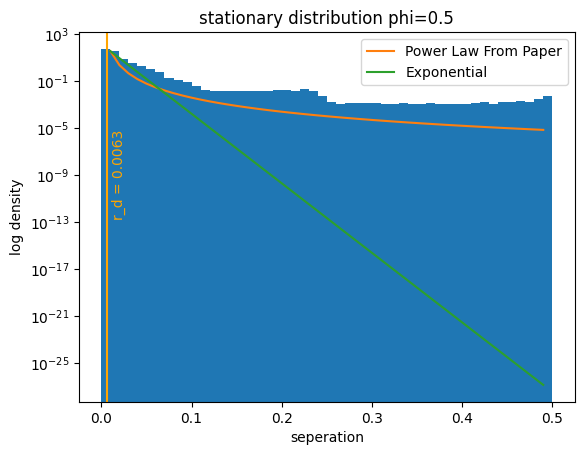

In [5]:
stationary_distribution(0.002*np.pi,0.5)#0.2*np.pi, 0.5)

r_d approx = 0.005234798182798985


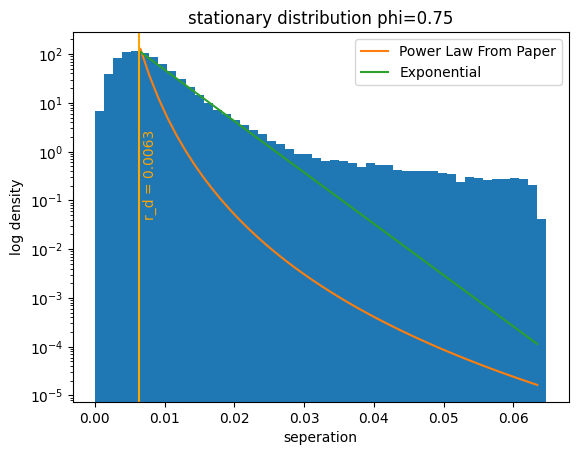

In [6]:
stationary_distribution(0.002*np.pi, 0.75)

r_d approx = 0.003921255992458557


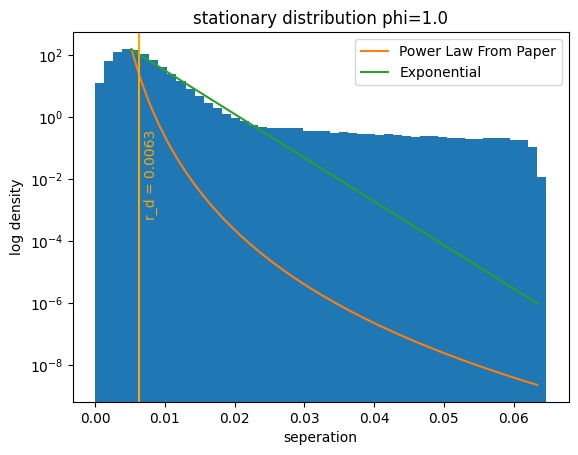

In [7]:
stationary_distribution(0.002*np.pi, 1.)

r_d approx = 0.0038621885132958072


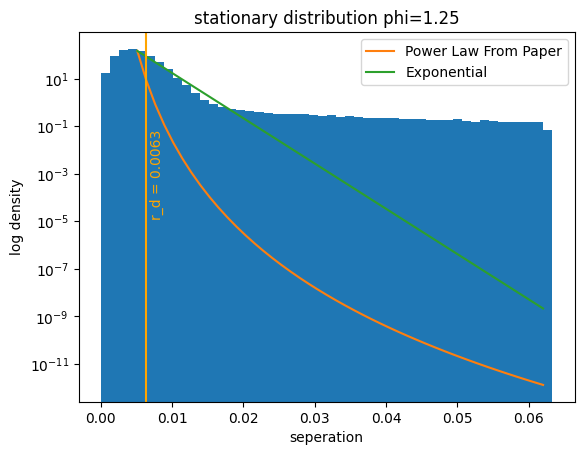

In [8]:
stationary_distribution(0.002*np.pi, 1.25)

r_d approx = 0.002554131605162898


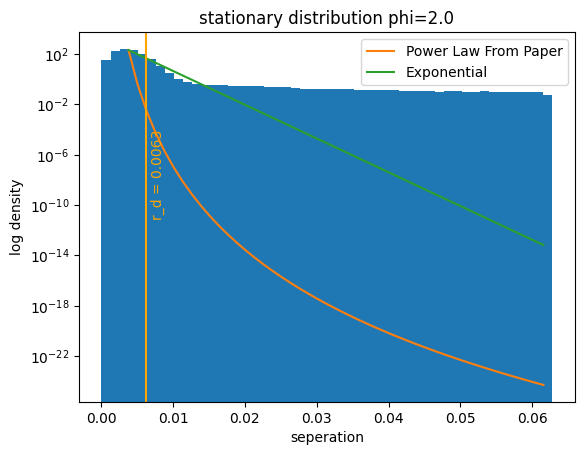

In [9]:
stationary_distribution(0.002*np.pi, 2.)

r_d approx = 0.08280085459339095


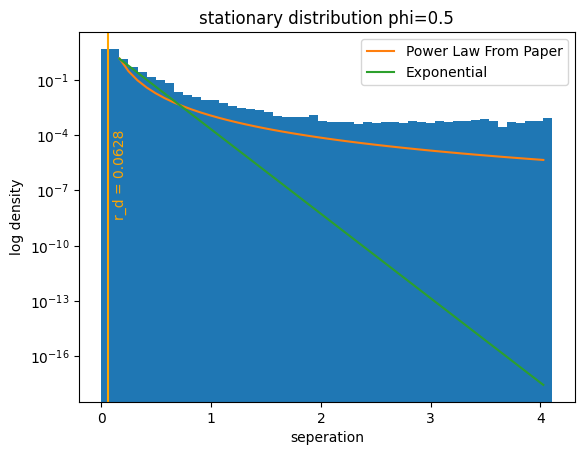

In [10]:
stationary_distribution(0.02*np.pi, 0.5)

r_d approx = 0.05408075402834221


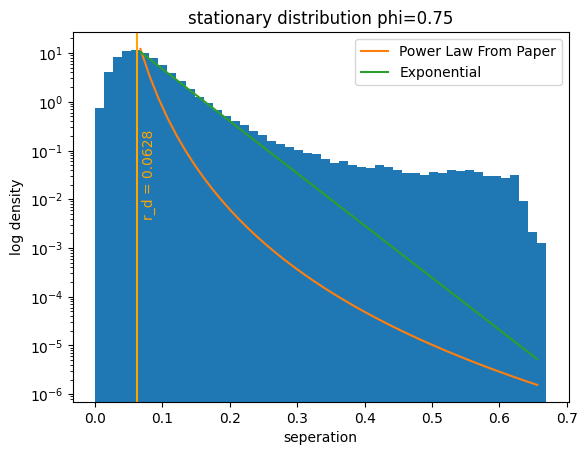

In [11]:
stationary_distribution(0.02*np.pi, 0.75)

r_d approx = 0.04003944370814602


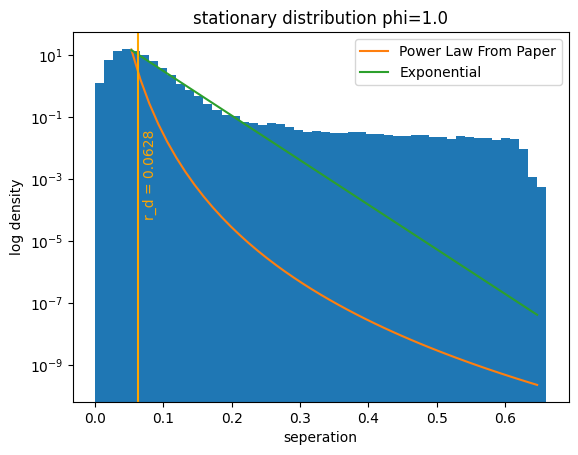

In [12]:
stationary_distribution(0.02*np.pi, 1.)

r_d approx = 0.03831965675892722


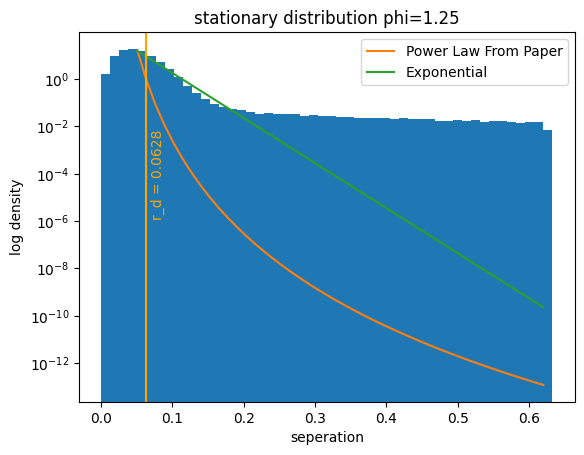

In [13]:
stationary_distribution(0.02*np.pi, 1.25)

r_d approx = 0.02541075108998289


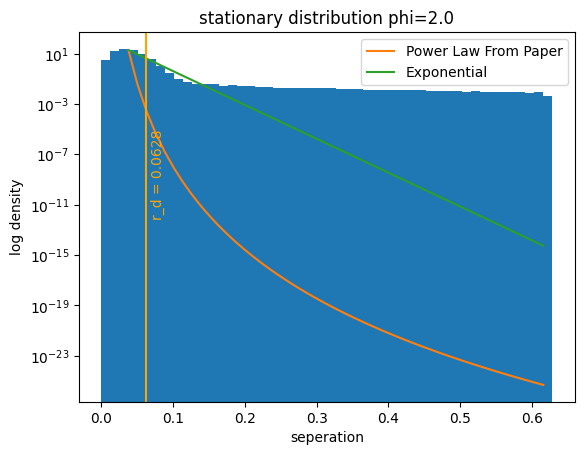

In [14]:
stationary_distribution(0.02*np.pi, 2.)

r_d approx = 0.6800282695595623


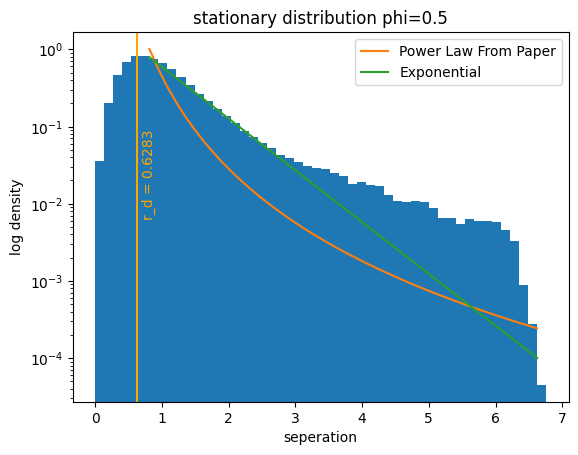

In [15]:
stationary_distribution(0.2*np.pi,0.5)#0.2*np.pi, 0.5)

r_d approx = 0.5209371595869223


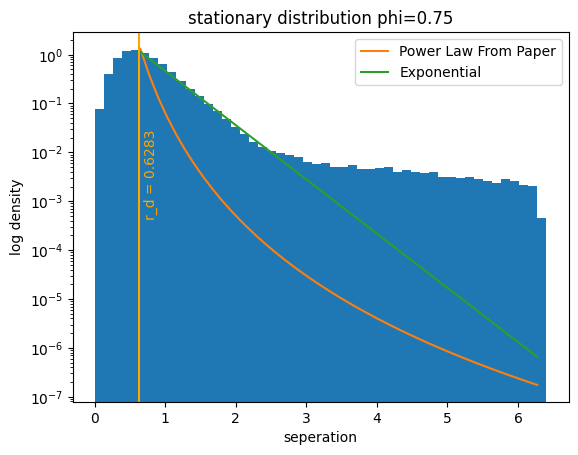

In [16]:
stationary_distribution(0.2*np.pi, 0.75)

r_d approx = 0.3817217590602701


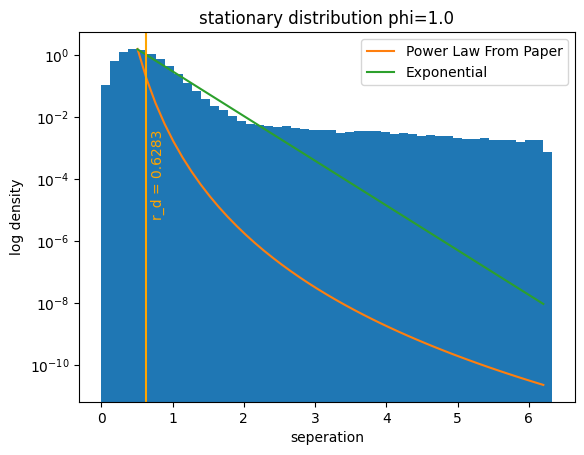

In [17]:
stationary_distribution(0.2*np.pi, 1.)

r_d approx = 0.38393928825838336


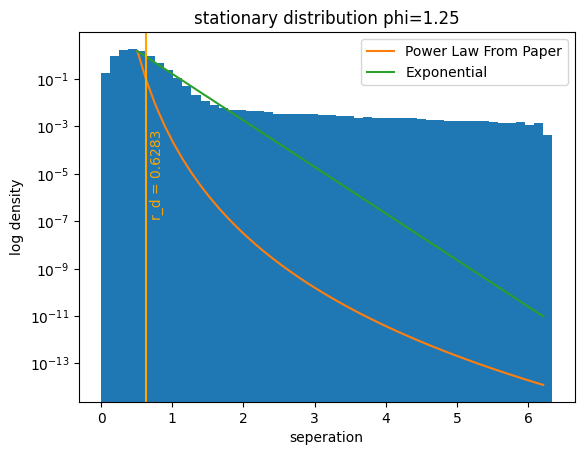

In [18]:
stationary_distribution(0.2*np.pi, 1.25)

r_d approx = 0.00013454504188807625


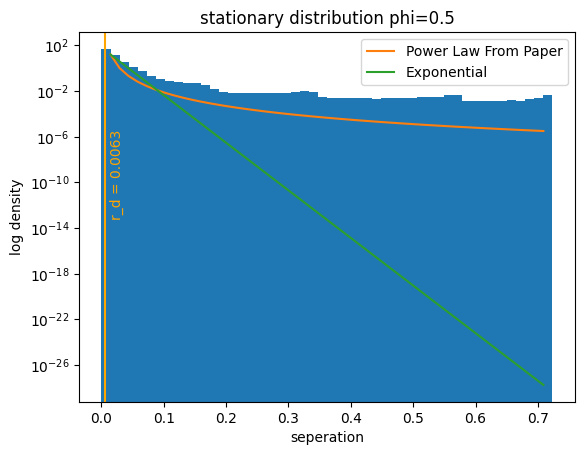

In [19]:
stationary_distribution(0.002*np.pi,0.5,a=1.0,b=0.6,c=0.6)#0.2*np.pi, 0.5)

r_d approx = 0.0046644285165579


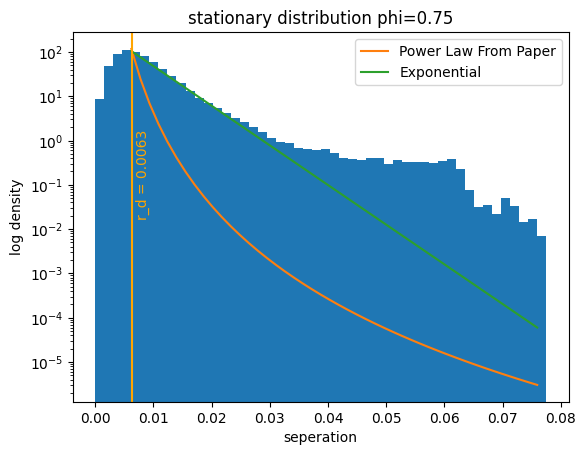

In [20]:
stationary_distribution(0.002*np.pi, 0.75,a=1.0,b=0.6,c=0.6)

r_d approx = 0.0038944046913026815


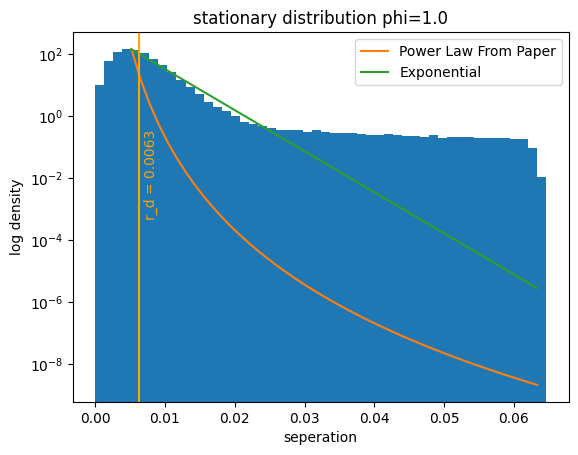

In [21]:
stationary_distribution(0.002*np.pi, 1.,a=1.0,b=0.6,c=0.6)

r_d approx = 0.003849831315935051


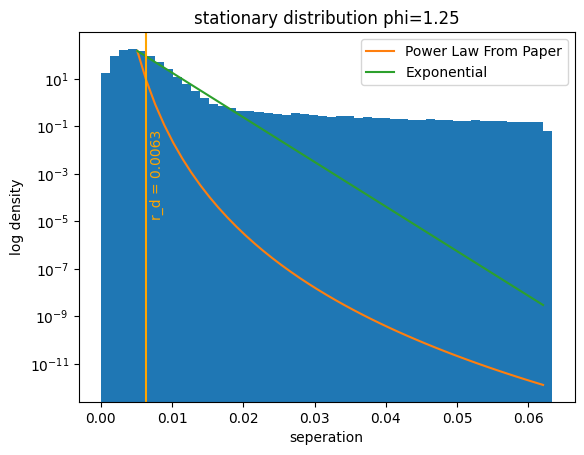

In [22]:
stationary_distribution(0.002*np.pi, 1.25,a=1.0,b=0.6,c=0.6)

r_d approx = 0.0025625242806930843


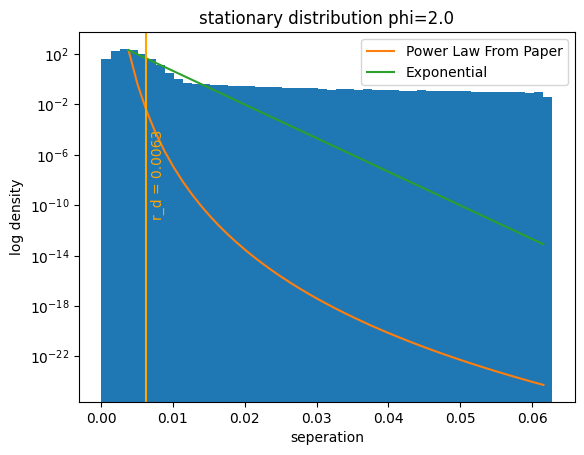

In [23]:
stationary_distribution(0.002*np.pi, 2.,a=1.0,b=0.6,c=0.6)

r_d approx = 0.0009073477796195347


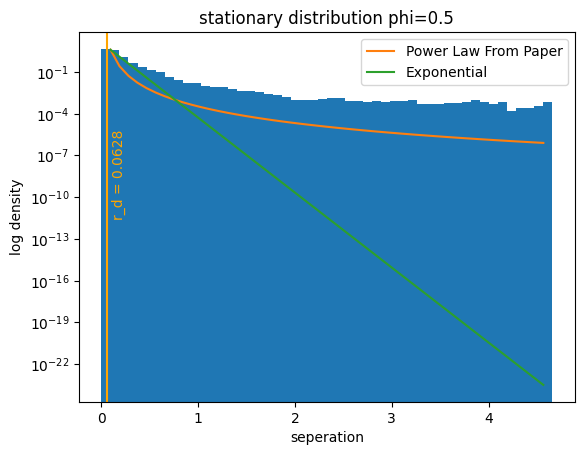

In [24]:
stationary_distribution(0.02*np.pi, 0.5,a=1.0,b=0.6,c=0.6)

r_d approx = 0.05403633758946264


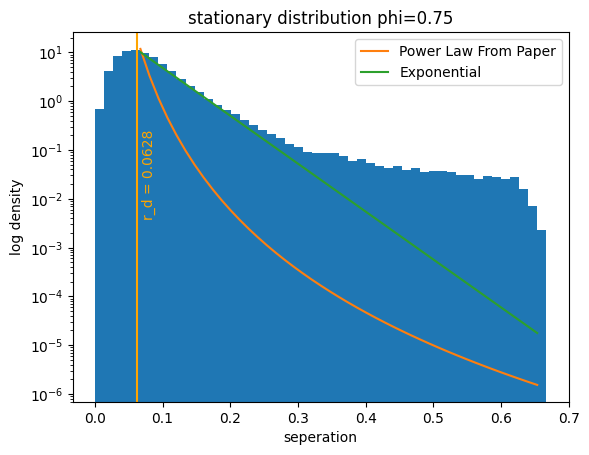

In [25]:
stationary_distribution(0.02*np.pi, 0.75,a=1.0,b=0.6,c=0.6)

r_d approx = 0.03925664395352339


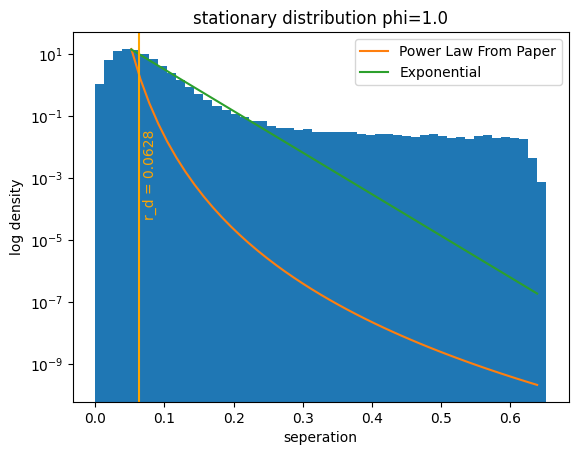

In [26]:
stationary_distribution(0.02*np.pi, 1.,a=1.0,b=0.6,c=0.6)

r_d approx = 0.03891289186327861


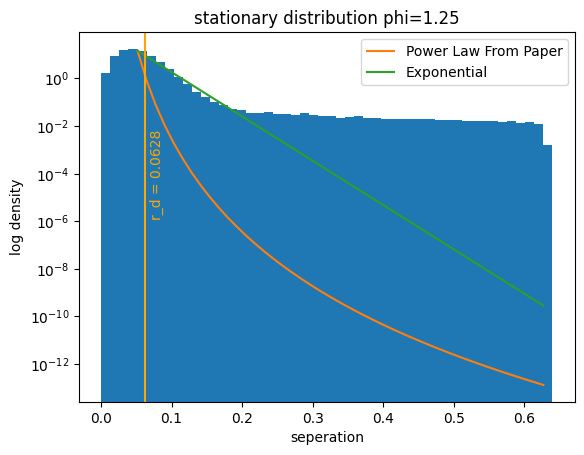

In [27]:
stationary_distribution(0.02*np.pi, 1.25,a=1.0,b=0.6,c=0.6)

r_d approx = 0.02570753029935308


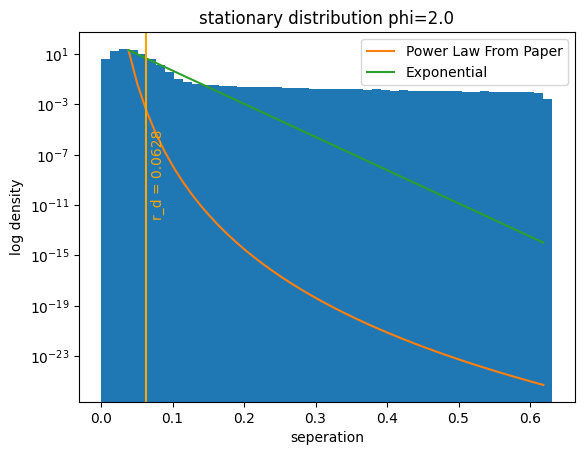

In [28]:
stationary_distribution(0.02*np.pi, 2.,a=1.0,b=0.6,c=0.6)

r_d approx = 0.6661597973909804


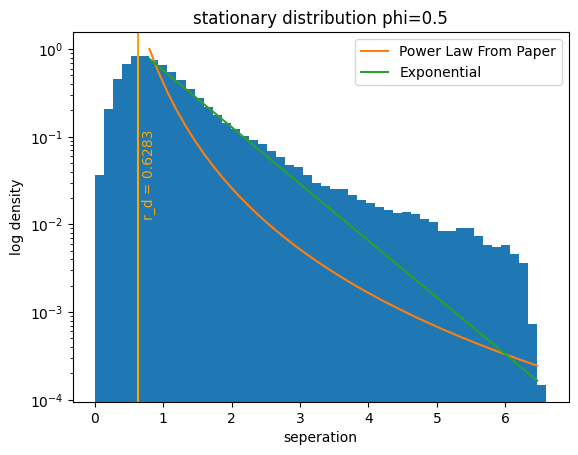

In [29]:
stationary_distribution(0.2*np.pi,0.5,a=1.0,b=0.6,c=0.6)#0.2*np.pi, 0.5)

r_d approx = 0.5159295991413814


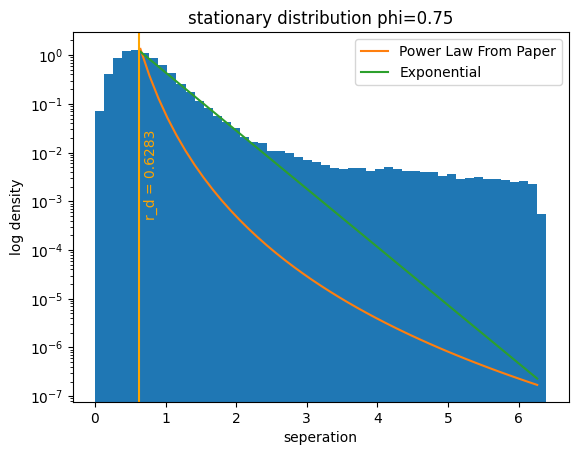

In [30]:
stationary_distribution(0.2*np.pi, 0.75,a=1.0,b=0.6,c=0.6)

r_d approx = 0.38632783112313546


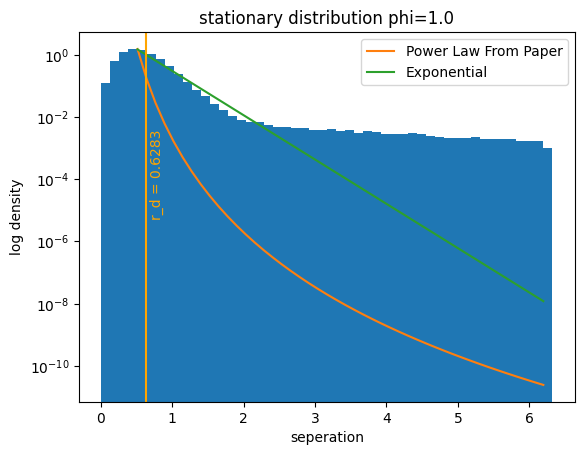

In [31]:
stationary_distribution(0.2*np.pi, 1.,a=1.0,b=0.6,c=0.6)

r_d approx = 0.3821170095312935


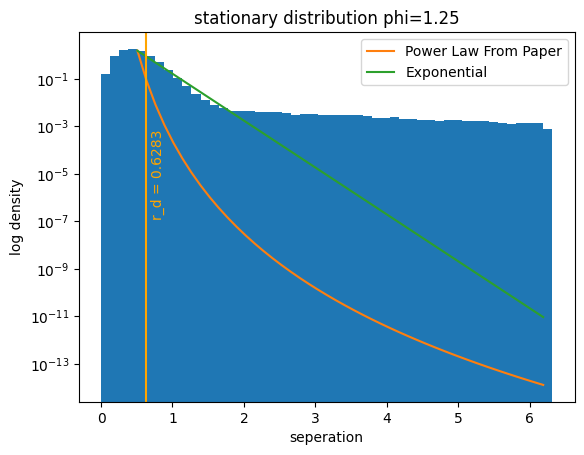

In [32]:
stationary_distribution(0.2*np.pi, 1.25,a=1.0,b=0.6,c=0.6)

r_d approx = 0.2536756920862887


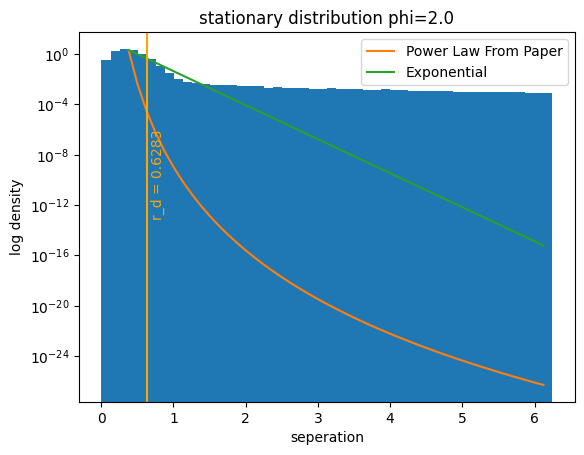

In [33]:
stationary_distribution(0.2*np.pi, 2.,a=1.0,b=0.6,c=0.6)

r_d approx = 0.2554952270602826


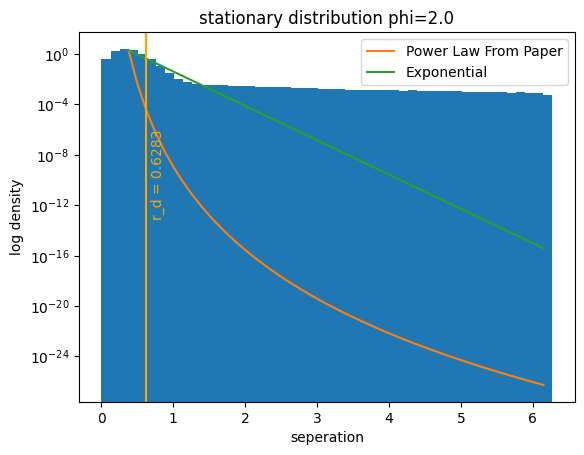

In [34]:
stationary_distribution(0.2*np.pi, 2.,a=1.0,b=0.6,c=0.6)

In [35]:
assert(1==0)

AssertionError: 

r_d approx = 3.131024161568997


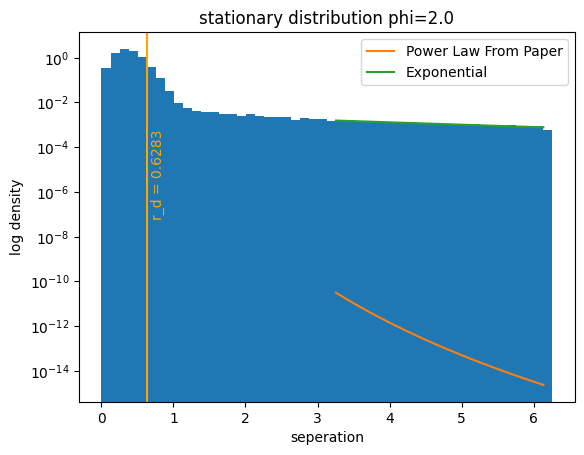

In [37]:
stationary_distribution(0.2*np.pi, 2.,a=1.0,b=0.6,c=0.6)

In [ ]:
plotLambda(5,seperate=False)

In [ ]:
for t in range(1,10):
    plotLambda(t,seperate=False)

In [ ]:
np.random.rand(3)-0.5

In [ ]:
np.arange(0,10,0.1)

In [ ]:
for i in range(5,6):
    print(i)

In [ ]:
np.random.rand()